In [1]:
# imports
import collections
import itertools
import random
import math
import string

import boruta
import IPython
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pyteomics import electrochem, mass, parser
from skbio.diversity.alpha import shannon
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing

%matplotlib inline

pd.options.display.max_rows = 12
pd.options.display.precision = 3
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['xtick.labelsize'] = 6

reading in boruta


## Reading and parsing input data

Data used by this notebook can be found in:
* data.csv
* control_data.csv

data.csv contains TCRbeta sequences that have been experimentally determined to bind to either the FLKEKGGL or EIYKRWII peptide (1).

control_data.csv contains TCRbeta sequences obtained by quering the ImmuneACCESS database (2) using the following terms: ‘human’, ‘TCRB’, ‘HLA-B\*08', 'CD8+' and 'control'. Raw data downloaded from ImmuneACCESS was parsed using the parse_immuneaccess_data.py (also located in this repo).

1. Costa AI, Koning D, Ladell K, McLaren JE, Grady BPX, Schellens IMM, van Ham P, Nijhuis M, Borghans JAM, Keşmir C, Price DA, van Baarle D. 2015. Complex T-Cell Receptor Repertoire Dynamics Underlie the CD8 T-Cell Response to HIV-1. J Virol 89:110–9.
2. https://clients.adaptivebiotech.com/immuneaccess

In [2]:
def split_rows(df, column_name, split_str):
    """
    Duplicates and splits rows in a pandas `DataFrame` based on the given split substring.
    
    Rows that contain the given split substring in the given column will be duplicated with each new row
    containing part of the split column in the corresponding column.
    
    Args:
        - df: The pandas `DataFrame` in which rows will be duplicated and split.
        - column_name: The name of the column in the given `DataFrame` on which rows will be duplicated and split.
        - split_str: The substring on which the column with the given name in the given `DataFrame` will be split.
        
    Returns:
        (A copy of) the `DataFrame` in which rows containing the given split substring in the given column are
        duplicated and split.
    """
    # split the indicated column on the given split substring
    split_column = df[column_name].str.split(split_str, expand=True).stack()
    # create a new dataframe with each of the split rows duplicated
    i = split_column.index.get_level_values(0)
    df2 = df.loc[i].copy().reset_index(drop=True)
    # assign the split substring to the indicated column
    df2[column_name] = split_column.values
    return df2


def gene_to_family(gene):
    """
    Reduce a (potentially compound) gene name to its family level.
    
    Args:
        - gene: A gene name. This can either consist of only a family name (single numeric format), a compound
                name of family and gene (numeric dash numeric format), or 'unresolved'.
                
    Returns:
        A string of length 2 containing the gene family name (optionally prepended with a 0), or 'unresolved'.
    """    
    gene_str = str(gene)
    if gene_str == 'unresolved':
        return gene_str
    else:
        return gene_str.split('-')[0].zfill(2)


def encode_gene(gene):
    """
    Uniformly encode genes as strings of length 2.
    
    If both the family and the gene name are known these are separated by a dash.
    
    Args:
        - gene: A gene name. This can either consist of only a family name (single numeric format), a compound
                name of family and gene (numeric dash numeric format), or 'unresolved'.

    Returns:
        The family and gene name as a string of length 2 separated by a dash if both are known, otherwise 
        'unresolved'.
    """
    gene_str = str(gene)
    if '-' in gene_str:
        return '-'.join(g.zfill(2) for g in gene_str.split('-'))
    else:
        return 'unresolved'

In [3]:
# read peptide data
peptide_data = pd.read_csv('data.csv')

# read control data; splits were already done during processing of immuneaccess data
control_data = pd.read_csv('control_data.csv')

# combine peptide and control data
data = pd.concat([peptide_data, control_data], ignore_index=True)
classes = data['HLA_peptide'].unique()

for gene in [gene for gene in data.columns.values if 'gene' in gene]:
    # split compound gene names (only really applicable to the V gene for the peptide data)
    data = split_rows(data, gene, '/')
    # uniformly encode all gene names
    data[gene] = data[gene].apply(lambda x: encode_gene(x))
    # explicitly add the gene family
    data[gene.replace('gene', 'family')] = data[gene].apply(lambda x: gene_to_family(x))

data = data[sorted(data.columns)]

## Data exploration

In [4]:
# calculate CDR3 sequence diversity of input data
stats = collections.defaultdict(list)
for peptide in classes:
    pep_data = data[data['HLA_peptide'] == peptide]
    
    stats['total TCRBs'].append(pep_data.shape[0])
    stats['unique CDR3'].append(len(set(pep_data['CDR3_sequence'])))
    
    cdr3_count = list(collections.Counter(pep_data['CDR3_sequence']).values())
    stats['CDR3 diversity'].append(shannon(cdr3_count))
    
    stats['unique V family'].append(len(pep_data['V_family'].unique()))
    stats['unique J family'].append(len(pep_data['J_family'].unique()))
    stats['unique V gene'].append(len(pep_data['V_gene'].unique()))
    stats['unique J gene'].append(len(pep_data['J_gene'].unique()))
    
    v_fam_count = list(collections.Counter(pep_data['V_family']).values())
    j_fam_count = list(collections.Counter(pep_data['J_family']).values())
    v_gene_count = list(collections.Counter(pep_data['V_gene']).values())
    j_gene_count = list(collections.Counter(pep_data['J_gene']).values())
    stats['V family diversity'].append(shannon(v_fam_count))
    stats['J family diversity'].append(shannon(j_fam_count))
    stats['V gene diversity'].append(shannon(v_gene_count))
    stats['J gene diversity'].append(shannon(j_gene_count))

IPython.display.display(pd.DataFrame(stats, index=classes, columns=stats.keys()).T)

,EIYKRWII,FLKEKGGL,Control
unique CDR3,119.000,70.000,54324.000
unique V gene,26.000,21.000,55.000
V family diversity,2.833,2.736,3.878
unique J gene,12.000,12.000,14.000
CDR3 diversity,6.820,5.916,15.706
J family diversity,0.930,0.932,0.976
J gene diversity,3.174,3.175,3.160
V gene diversity,3.574,3.545,4.599
unique J family,2.000,2.000,3.000
total TCRBs,142.000,95.000,56023.000


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


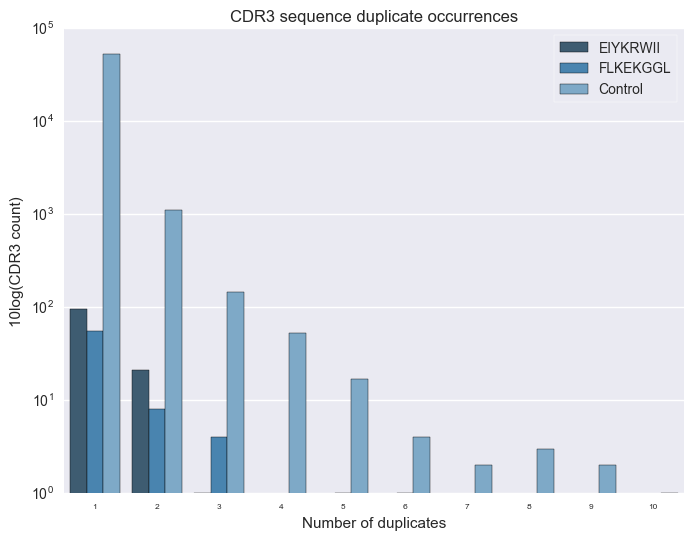

In [5]:
# plot the number of duplicates per CDR3 sequence
counts = []
for peptide in classes:
    count = data[data['HLA_peptide'] == peptide]['CDR3_sequence'].value_counts()
    counts.append(pd.DataFrame({'counts': count, 'peptide': [peptide] * len(count)}))

plt.figure(figsize=(8, 6))

sns.countplot(x='counts', hue='peptide', data=pd.concat(counts), palette='Blues_d')

plt.yscale('log')

plt.title('CDR3 sequence duplicate occurrences')

plt.xlabel('Number of duplicates')
plt.ylabel('10log(CDR3 count)')

plt.legend(loc='upper right', frameon=True)

plt.savefig('CDR3sequence_distribution.pdf', bbox_inches='tight', dpi=600)
plt.show()
plt.close()

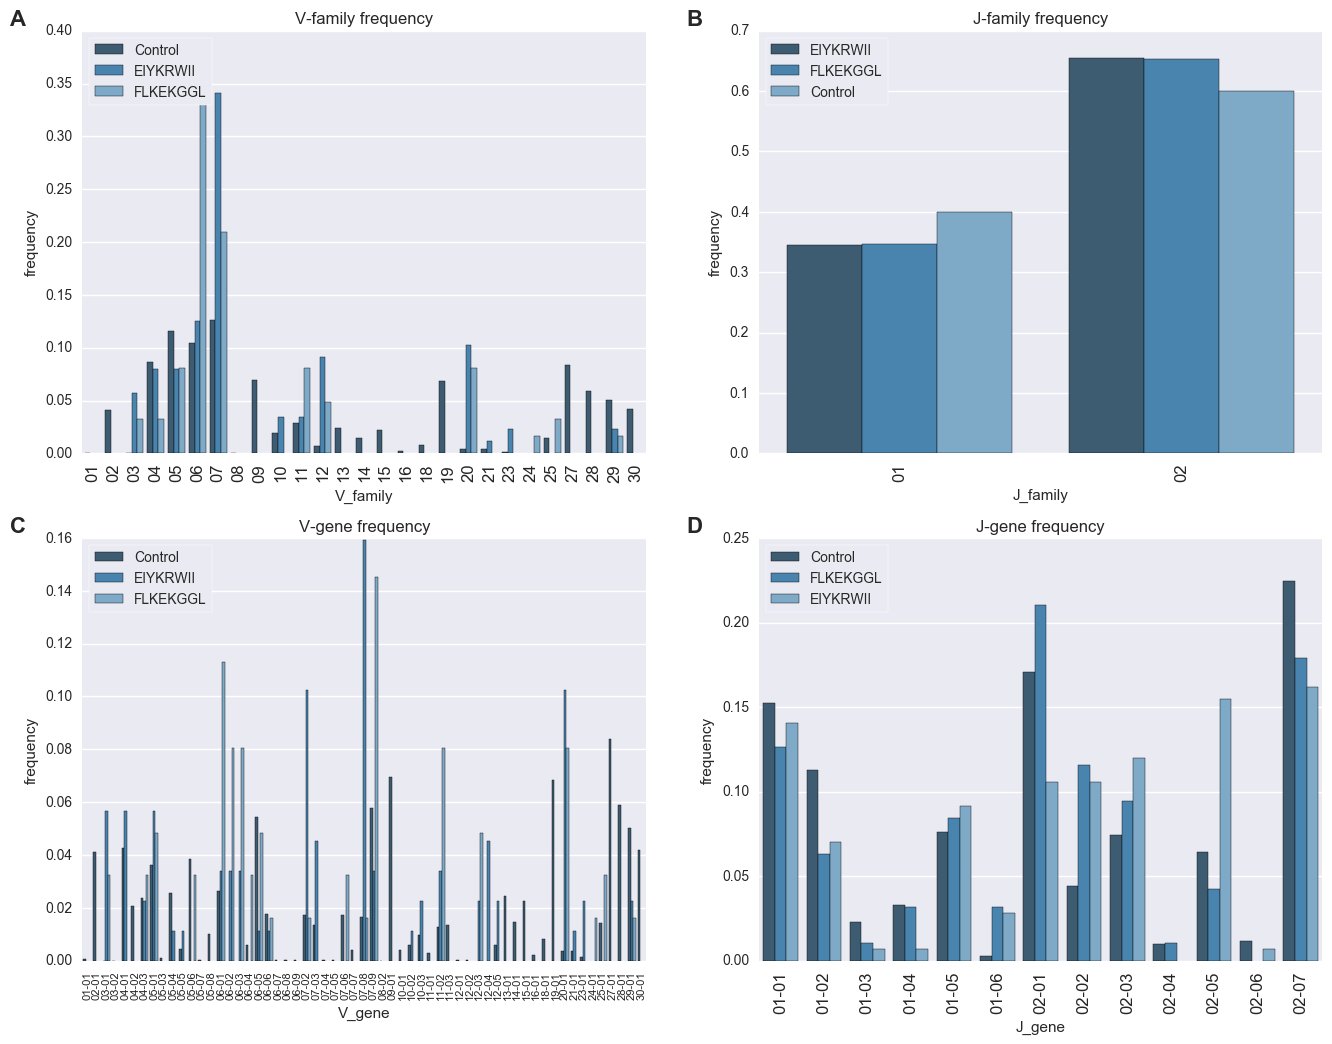

In [24]:
f, axarr = plt.subplots(2, 2, figsize=(16, 12))
cnt = 0

# show V_gene and J_gene usage at family level
for gene in ['V_family', 'J_family', 'V_gene', 'J_gene']:

    gene_freqs = []
    for peptide in classes:
        peptide_counts = data[(data['HLA_peptide'] == peptide) & (data[gene] != 'unresolved')][gene].value_counts(normalize=True, sort=False)
        gene_freqs.append(pd.DataFrame({'gene': peptide_counts.index, 'frequency': peptide_counts.values,
                                        'peptide': [peptide] * len(peptide_counts)}))
    gene_freqs = pd.concat(gene_freqs).sort_values(by='gene')
    
    sns.barplot(x='gene', y='frequency', hue='peptide', data=gene_freqs, palette='Blues_d', ax=axarr[int((cnt)/2), int((cnt)%2)])

    axarr[int((cnt)/2), int((cnt)%2)].set_title('{} frequency'.format(gene.replace('_', '-')))
    
    axarr[int((cnt)/2), int((cnt)%2)].set_xlabel('{}'.format(gene))
    axarr[int((cnt)/2), int((cnt)%2)].set_ylabel('frequency')

    if gene == 'V_gene':
        axarr[int((cnt)/2), int((cnt)%2)].set_xticklabels(sorted(set(gene_freqs['gene'].values)), 
                                                          rotation='vertical', size=8)
    else:
        axarr[int((cnt)/2), int((cnt)%2)].set_xticklabels(sorted(set(gene_freqs['gene'].values)), 
                                                          rotation='vertical', size=12)
    
    axarr[int((cnt)/2), int((cnt)%2)].legend(loc='best', frameon=True)
    
    axarr[int((cnt)/2), int((cnt)%2)].annotate(string.ascii_uppercase[cnt], xy=(-0.1,1.1), 
                                               xycoords='axes fraction', fontsize=16,
                                               xytext=(0, -15), textcoords='offset points', 
                                               weight='bold', ha='right', va='top')
    
    cnt += 1
    
plt.savefig('VJ_distribution.pdf',bbox_inches='tight', dpi=600)
plt.show()
plt.close()
    

## Feature generation

For each sequence the following features were generated:
* V- & J-gene and -family occurrence
 
* Sequence length (computed by [Pyteomics](https://pythonhosted.org/pyteomics/) [Goloborodko2013], modX notation allowed).
* Amino acid count
* Average amino acid physico-chemical properties over the CDR3 sequence length (basicity, hydrophobicity, helicity, mutational stability)
* Sequence pI (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* Peptide mass (computed by [Pyteomics](https://pythonhosted.org/pyteomics/)).
* Position-specific amino acid presence
* Position-specific physico-chemical amino acid properties, pI and mass.

Individual features of each amino acid at specific positions in the sequences were encoded as follows:
* For sequences with an odd length, the center amino acid is assigned index `0`, with ascending indices to the right and descending indices to the left. For sequences with an even length there is no `0` index, but the center two amino acids have index `-1` and `1`.
* For each position the following features are generated: which amino acid occurs at this position; the basicity, hydrophobicity, helicity, pI, and substitution value for the amino acid at this position.

Categorical attributes were one-hot encoded. This is useful because most classification algorithms are not able to deal with categorical features but require numerical features instead.

[Goloborodko2013] Goloborodko, A. A., Levitsky, L. I., Ivanov, M. V. & Gorshkov, M. V. Pyteomics-a Python framework for exploratory data analysis and rapid software prototyping in proteomics. *Journal of The American Society for Mass Spectrometry* **24**, 301–304 (2013).

In [7]:
# physico-chemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchem_properties = {'basicity': basicity, 'hydrophobicity': hydrophobicity,
                       'helicity': helicity, 'mutation stability': mutation_stability}

In [8]:
def compute_features(data):
    """
    TODO
    """
    features_list = []
    
    # non-positional features (i.e. over the whole sequence)

    # one-hot encode V- and J-genes and -families
    onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
    features_list.append(pd.DataFrame(
        onehot_encoder.fit_transform(data[['V_gene', 'J_gene', 'V_family', 'J_family']].to_dict(orient='records')),
        columns=onehot_encoder.feature_names_))
    
    # sequence length
    features_list.append(data['CDR3_sequence'].apply(lambda sequence: parser.length(sequence)).to_frame()
                         .rename(columns={'CDR3_sequence': 'length'}))

    # number of occurences of each amino acid
    aa_counts = pd.DataFrame.from_records(
        [parser.amino_acid_composition(sequence) for sequence in data['CDR3_sequence']]).fillna(0)
    aa_counts.columns = ['{} count'.format(column) for column in aa_counts.columns]
    features_list.append(aa_counts)

    # average physico-chemical properties
    for prop_name, prop_lookup in physchem_properties.items():
        features_list.append(data['CDR3_sequence'].apply(
            lambda sequence: np.mean(list(prop_lookup[aa] for aa in sequence)))
                               .to_frame().rename(columns={'CDR3_sequence': 'average {}'.format(prop_name)}))
    # pI
    features_list.append(data['CDR3_sequence'].apply(
        lambda sequence: electrochem.pI(sequence)).to_frame().rename(columns={'CDR3_sequence': 'pI'}))
    
    # positional features (i.e. localized at a specific amino acid position)
    pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_mutation, pos_pI = [[] for _ in range(6)]
    for sequence in data['CDR3_sequence']:
        length = parser.length(sequence)
        start_pos = -1 * (length // 2)
        pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                    list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))

        pos_aa.append({'pos_{}_{}'.format(pos, aa): 1 for pos, aa in zip(pos_range, sequence)})
        pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                          for pos, aa in zip(pos_range, sequence)})
        pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                             for pos, aa in zip(pos_range, sequence)})
        
        pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                       for pos, aa in zip(pos_range, sequence)})

    features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))
    features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
    
    return pd.concat(features_list, axis=1)

In [9]:
# compute features for each observation
features = compute_features(data)
X = features.values
feature_names = features.columns.values
peptide_encoder = preprocessing.LabelEncoder()
y = peptide_encoder.fit_transform(data['HLA_peptide'])

## Classification

In [10]:
def create_indices(y, pos_label=1, neg_label=0, n_splits=10, test_size=0.1, train_size=None,
                   neg_multiplier=1, random_state=None):
    """
    Yields train and test indices for unbalanced data sets.
    
    Args:
        - y: The class labels.
        - pos_label: Label denoting the positive (small) class.
        - neg_label: Label denoting the negative (large) class.
        - n_splits: Number of splitting iterations.
        - test_size: The proportion of the positive samples to include in the test split.
        - train_size: The proportion of positive samples to include in the train split. If None,
                      the value is automatically set to the complement of the test size.
        - neg_multiplier: Number of times the negative set is larger than the positive set.
        - random_state: Seed used by the random number generator.
        
    Returns:
        A tuple of the training indices and test indices of the current split.
    """
    np.random.seed(random_state)
    
    if train_size is None:
        train_size = 1 - test_size
    
    pos_idx = np.where(y == pos_label)[0]
    neg_idx = np.where(y == neg_label)[0]
    num_pos = len(pos_idx)
    
    pos_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                test_size=int(num_pos * test_size),
                                                train_size=int(num_pos * train_size),
                                                random_state=random_state)
    neg_splitter = model_selection.ShuffleSplit(n_splits=n_splits,
                                                test_size=int(num_pos * test_size * neg_multiplier),
                                                train_size=int(num_pos * train_size * neg_multiplier),
                                                random_state=random_state)
    
    for (pos_train_idx, pos_test_idx), (neg_train_idx, neg_test_idx) in\
            zip(pos_splitter.split(pos_idx), neg_splitter.split(neg_idx)):
        train_idx = np.concatenate((pos_idx[pos_train_idx], neg_idx[neg_train_idx]))
        np.random.shuffle(train_idx)
        test_idx = np.concatenate((pos_idx[pos_test_idx], neg_idx[neg_test_idx]))
        np.random.shuffle(test_idx)

        yield train_idx, test_idx
              


def predict(predictor, X, y, train_idx, test_idx):
    """
    Run a single iteration of the predictor.
    
    This is extracted to a method for multithreaded computation using joblib.
    
    Args:
        - predictor: A scikit-learn compatible predictor. The predictor needs to be able to generate probabilities
                     (method `predict_proba`) and export feature importances (attribute `feature_importances_`).
        - X: Input values.
        - y: Target values.
        - train_idx: The indices of the training set.
        - test_idx: The indices of the test set.
        
    Returns:
        A tuple consisting of the target classes, the predicted class probabilities, and the feature importances.
    """    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train the predictor pipeline
        predictor.fit(X_train, y_train)
    
        # extract the relevant feature importances
        importances = np.zeros(X_train.shape[1], float)
        importances[predictor.named_steps['feature_selection'].support_] =\
            predictor.named_steps['classification'].feature_importances_

        # return the predictions to evaluate the performance
        predictions_proba = predictor.predict_proba(X_test)[:, 1]

        # combine the ground truth with the predictions for future reference
        return y_test, predictions_proba, importances

In [11]:
# number of trees in the random forest
n_trees = 200

# create a prediction pipeline consisting of feature selection and classification
# this is an unbalanced classification problem so weight the classes inversely proportional to their frequencies
classifier = ensemble.RandomForestClassifier(n_trees, n_jobs=-1, random_state=0, class_weight='balanced')
feature_selection = boruta.BorutaPy(ensemble.ExtraTreesClassifier(n_jobs=-1), n_estimators='auto', random_state=0)

predictor = pipeline.Pipeline([('feature_selection', feature_selection), ('classification', classifier)])

In [12]:
peptide_predictions = []
for peptide in classes:
    if peptide == 'Control':
        continue
        
    # use 10 times as many negative samples as positive samples in 5 iterations
    index_generator = create_indices(y,
                                     peptide_encoder.transform([peptide])[0],
                                     peptide_encoder.transform(['Control'])[0],
                                     5, 0.2, 0.8, 10)

    result = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(predict)
                                                   (predictor, X, y, train_idx, test_idx)
                                                   for train_idx, test_idx in index_generator))

    predictions = []
    predictions_proba = []
    feature_importances = []
    for y_test, proba, feat in result:
        predictions.append((np.array(y_test != 0, np.int), np.array(proba > 0.5, np.int)))
        predictions_proba.append((np.array(y_test != 0, np.int), proba))
        feature_importances.append(feat)

    peptide_predictions.append((peptide, predictions, predictions_proba, feature_importances))

EIYKRWII
Classification accuracy = 94.68% ± 0.66%
FLKEKGGL
Classification accuracy = 94.93% ± 0.65%


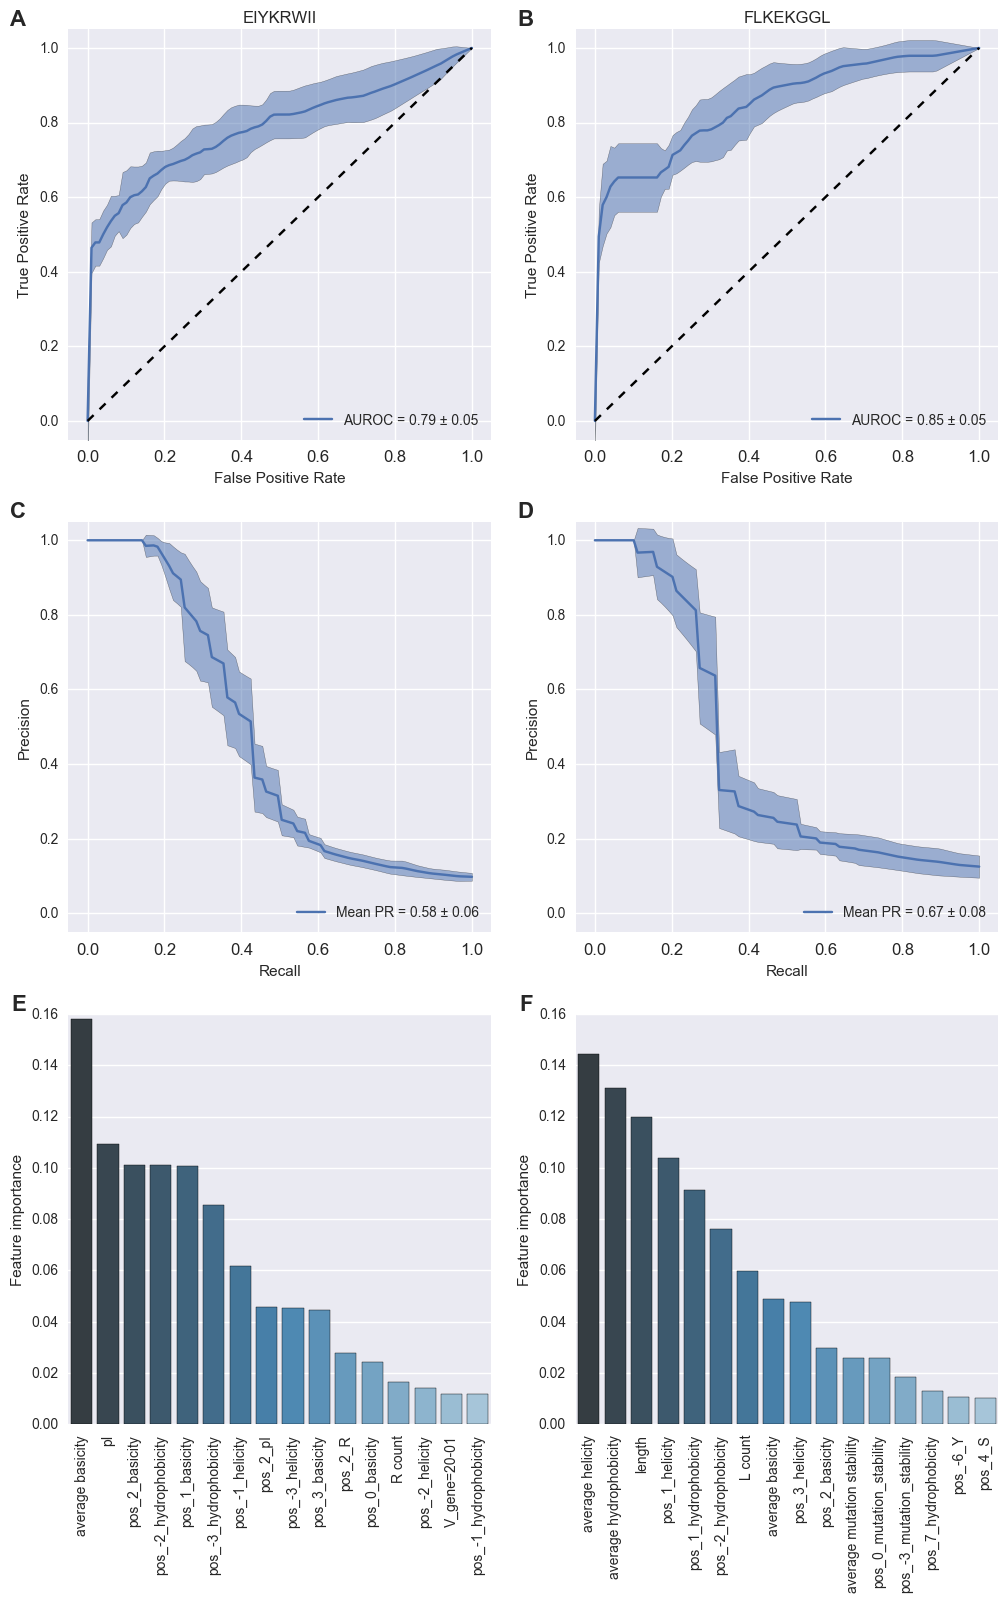

In [16]:
f, axarr = plt.subplots(3, 2, figsize=(12, 18))
cnt = 0

for peptide, predictions, predictions_proba, feature_importances in peptide_predictions:
    # evaluate the performance of the prediction pipeline
    # accuracy (although not particularly useful for this unbalanced class problem)
    accuracy_mean = np.mean([metrics.accuracy_score(y_test, y_pred)
                             for y_test, y_pred in predictions])
    accuracy_std = np.std([metrics.accuracy_score(y_test, y_pred)
                           for y_test, y_pred in predictions])

    # AUC and average precision
    auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred)
                        for y_test, y_pred in predictions_proba])
    auc_std = np.std([metrics.roc_auc_score(y_test, y_pred)
                      for y_test, y_pred in predictions_proba])
    avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred)
                                  for y_test, y_pred in predictions_proba])
    avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred)
                                for y_test, y_pred in predictions_proba])
    avg_precision_inverted_mean = np.mean([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                           for y_test, y_pred in predictions_proba])
    avg_precision_inverted_std = np.std([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                         for y_test, y_pred in predictions_proba])

    # mean and standard deviation of ROC and precision-recall curves
    interval = np.linspace(0, 1, 100)
    tprs, precisions, precisions_inverted = [], [], []
    for y_test, y_pred in predictions_proba:
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
        tprs.append(np.interp(interval, fpr, tpr))

        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        precisions.append(np.interp(interval, recall[::-1], precision))

        # inverted precision
        precision_inverted, recall_inverted, _ = metrics.precision_recall_curve(1 - y_test, 1 - y_pred)
        precisions_inverted.append(np.interp(interval, recall_inverted[::-1], precision_inverted))

    tpr_mean = np.mean(tprs, axis=0)
    tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
    tpr_std = np.std(tprs, axis=0)
    precision_mean = np.mean(precisions, axis=0)
    precision_std = np.std(precisions, axis=0)
    precision_inverted_mean = np.mean(precisions_inverted, axis=0)
    precision_inverted_std = np.std(precisions_inverted, axis=0)

    # print accuracy
    print(peptide)
    print('Classification accuracy = {:.2%} ± {:.2%}'.format(accuracy_mean, accuracy_std))

    # plot ROC curve

    axarr[0, 0+cnt].plot(interval, tpr_mean, label='AUROC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
    axarr[0, 0+cnt].fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

    axarr[0, 0+cnt].plot([0, 1], [0, 1], 'k--')
    
    axarr[0, 0+cnt].set_xlim([-0.05, 1.05])
    axarr[0, 0+cnt].set_ylim([-0.05, 1.05])

    axarr[0, 0+cnt].set_title(peptide)

    axarr[0, 0+cnt].set_xlabel('False Positive Rate')
    axarr[0, 0+cnt].set_ylabel('True Positive Rate')

    axarr[0, 0+cnt].legend(loc='lower right')
    
    axarr[0, 0+cnt].annotate(string.ascii_uppercase[cnt], xy=(-0.1,1.1), xycoords='axes fraction', fontsize=16,
                          xytext=(0, -15), textcoords='offset points', weight='bold',
                          ha='right', va='top')
    
    # plot precision-recall curve
    axarr[1, 0+cnt].plot(interval[::-1], precision_mean,
             label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
    axarr[1, 0+cnt].fill_between(interval[::-1], precision_mean - precision_std,
                     precision_mean + precision_std, alpha=0.5)
    
    axarr[1, 0+cnt].set_xlim([-0.05, 1.05])
    axarr[1, 0+cnt].set_ylim([-0.05, 1.05])
    
    axarr[1, 0+cnt].set_xlabel('Recall')
    axarr[1, 0+cnt].set_ylabel('Precision')
    
    axarr[1, 0+cnt].legend(loc='lower right')

    axarr[1, 0+cnt].annotate(string.ascii_uppercase[cnt+2], xy=(-0.1,1.1), xycoords='axes fraction', fontsize=16,
                          xytext=(0, -15), textcoords='offset points', weight='bold',
                          ha='right', va='top')
    
    # plot feature importances
    feat_import_s = pd.Series(np.mean(feature_importances, axis=0),
                              index=feature_names, name='Feature importances')
    significant_features = feat_import_s[feat_import_s > 0.01].sort_values(ascending=False)

    sns.barplot(x=significant_features.index.values, y=significant_features, palette='Blues_d', ax=axarr[2, 0+cnt])

    axarr[2, 0+cnt].set_xticklabels(significant_features.index.values, rotation='vertical', fontsize=10)
    axarr[2, 0+cnt].set_ylabel('Feature importance')
    
    axarr[2, 0+cnt].annotate(string.ascii_uppercase[cnt+4], xy=(-0.1,1.1), xycoords='axes fraction', fontsize=16,
                          xytext=(0, -15), textcoords='offset points', weight='bold',
                          ha='right', va='top')

    cnt += 1
    
plt.savefig('validation_many.pdf'.format(peptide), bbox_inches='tight', dpi=600)
plt.show()
plt.close()

## Learning curve

In [14]:
def scorer(estimator, X, y):
    print(y, estimator.predict_proba(X))
    pred = 1 - estimator.predict_proba(X)[:, 0]
    return metrics.roc_auc_score(y, pred)

learning_curve_stats = []
for peptide in classes:
    if peptide == 'Control':
        continue
    
    # use 10 times as many negative samples as positive samples in 5 iterations
    index_generator = create_indices(y,
                                     peptide_encoder.transform([peptide])[0],
                                     peptide_encoder.transform(['Control'])[0],
                                     5, 0.2, 0.8, 10)
    
    # compute the learning curve
    y_binary = np.array(y == peptide_encoder.transform([peptide])[0], np.int)
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        classifier, X, y_binary, train_sizes=np.linspace(.1, 1., 10),
        scoring='roc_auc', n_jobs=-1, cv=index_generator)
        
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    learning_curve_stats.append((peptide, train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std))

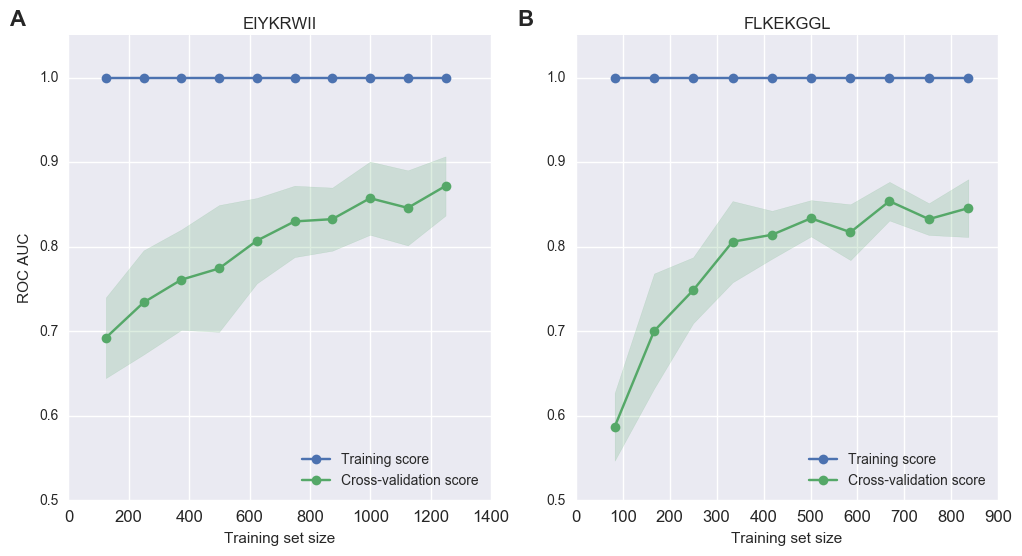

In [17]:
f, axarr = plt.subplots(1, 2, figsize=(12, 6))
cnt = 0

for peptide, train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std in learning_curve_stats:

    # plot the learning curve
    axarr[0+cnt].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color=sns.color_palette()[0])
    axarr[0+cnt].plot(train_sizes, train_scores_mean, 'o-', label='Training score')

    axarr[0+cnt].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color=sns.color_palette()[1])
    axarr[0+cnt].plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')

    axarr[0+cnt].set_title(peptide)
    
    axarr[0+cnt].set_xlabel('Training set size')
    if cnt == 0:
        axarr[0+cnt].set_ylabel('ROC AUC')

    axarr[0+cnt].set_ylim(0.5, 1.05)

    axarr[0+cnt].legend(loc='lower right')
    
    axarr[0+cnt].annotate(string.ascii_uppercase[cnt], xy=(-0.1,1.1), xycoords='axes fraction', fontsize=16,
                          xytext=(0, -15), textcoords='offset points', weight='bold',
                          ha='right', va='top')
    cnt += 1

plt.savefig('learning_curve_many.pdf'.format(peptide), bbox_inches='tight', dpi=600)
plt.show()
plt.close()